## Regression Project: Predicting Home Values 

The Zillow Data Science Team wants to be able to predict the values of single unit properties that the tax district assesses based on their data based on property transactions during May through August 2017. Properties are all located in Los Angeles County, Orange County or Ventura County, California

Data Source: Zillow database on Codeup's data server.

All files referenced in this presentation are available in the github repository for this project:   https://github.com/barbmarques/zillow-regression-project.


#### Project Goals:
- Predict the tax value of single unit properties in the Ventura County, Los Angeles County and Orange County, California. 
- Determine the distribution of tax rates for each county. 

#### Initial Questions: 
- Does the lot size affect the value of the house?
- Does the county a home is located in affect the value of the home?
- Does the age of a home affect the value of the home?
    

### Quick Links to Sections within this Notebook

- [Acquire Data](#AD)
- [Prepare Data](#PD)
- [Split Data](#SD)
- [Scale Data](#Scale)
- [Explore Data](#Explore)
- [Hypothesis Testing](#HypoCorr)
- [Create a Baseline Model](#Baseline)
- [Model Data (train & validate)](#Model)
- [Feature Engineering](#Feature)
- [Model on Test Data](#Test)
- [Model Visualizations](#Visual)
- [Tax Distribution by County](#Rates)
- [Recommendations & Key Takeaways](#Recommends)

In [1]:
#basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from scipy import stats


import sklearn.preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, QuantileTransformer
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.metrics import mean_squared_error,r2_score,explained_variance_score
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

# Import created modules
import env
import wrangle_zillow
import explore

# Clear pink warning boxes
import warnings
warnings.filterwarnings("ignore")

# Handle large numbers w/o using scientific notation
pd.options.display.float_format = '{:.3f}'.format

<a id='AD'></a>
### ```Acquire Data```

In [2]:
df = wrangle_zillow.acquire('zillow')
df.head()

,bathroomcnt,bedroomcnt,yearbuilt,calculatedfinishedsquarefeet,lotsizesquarefeet,parcelid,fips,regionidzip,taxvaluedollarcnt,taxamount
0,2.000,3.000,1923.000,1316.000,5672.000,11721753,6037.000,95997.000,205123.000,2627.480
1,2.000,3.000,1970.000,1458.000,8284.000,11289917,6037.000,97318.000,136104.000,2319.900
2,2.000,3.000,1980.000,1766.000,25082.000,11637029,6037.000,96086.000,810694.000,9407.010
3,3.000,4.000,2003.000,2541.000,4975.000,14269464,6059.000,96958.000,880456.000,9819.720
4,2.000,3.000,1955.000,1491.000,5000.000,11446756,6037.000,96162.000,107110.000,1399.270


In [3]:
print(f'My original dataframe is coming in with {df.shape[0]} rows and {df.shape[ 1]} columns.')

My original dataframe is coming in with 30259 rows and 10 columns.


#### ```Takeaways: ```
    
- Pulled in data for the months of 5/1/2017 - 8/31/2017.

- Only properties with a unit count of 1, which includes Single Family Residence, Rural Residence, Mobile Home, Town House, Bungalow, Zero Lot Line, Patio Home and Inferred Single Family Residential 
- Initial exploration revealed outliers, so the acquire query was adjusted as follows:
- Only square footages from 700 - 5500
- Assessed with tax values between 90,000 and 3,100,000
- 1-8 bedrooms and 1-7 baths

Initial review of the data within Sequel revealed: 
    
- bathroomcnt, bedroomcnt, fips, parcelid have no nulls
- 10,550 of buildingqualitytypeid are null, so I will remove this feature.  
- Replace it with yearbuilt - which has 83 nulls
- calculatedfinishedsquarefeet had 60 nulls
- lotsizesquarefeet has 663 nulls
- regionidzip has 22 nulls
    
    

<a id='PD'></a>
### ```Prepare Data```

In [4]:
df = wrangle_zillow.prep_zillow(df)
df.head()

,bathrooms,bedrooms,age,square_feet,lot_size,fips,zip_code,tax_value,taxes
parcel_id,,,,,,,,,
11721753,2,3,94,1316,5672.000,6037,95997,205123.000,2627.480
11289917,2,3,47,1458,8284.000,6037,97318,136104.000,2319.900
11637029,2,3,37,1766,25082.000,6037,96086,810694.000,9407.010
14269464,3,4,14,2541,4975.000,6059,96958,880456.000,9819.720
11446756,2,3,62,1491,5000.000,6037,96162,107110.000,1399.270


#### ```Takeaways:```
When ```prep_zillow``` is called:

- The index is reset to parcel_id as it is a unique identifier for each observation.
    
- Features/columns are renamed
    
- The yearbuilt feature is recalculated to age in years since construction.
    
- Data types are changed to int or float, as appropriate


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30259 entries, 11721753 to 10713993
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bathrooms    30259 non-null  int64  
 1   bedrooms     30259 non-null  int64  
 2   age          30259 non-null  int64  
 3   square_feet  30259 non-null  int64  
 4   lot_size     30259 non-null  float64
 5   fips         30259 non-null  int64  
 6   zip_code     30259 non-null  int64  
 7   tax_value    30259 non-null  float64
 8   taxes        30259 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 2.3 MB


In [6]:
df.shape

(30259, 9)

In [7]:
df.columns

Index(['bathrooms', 'bedrooms', 'age', 'square_feet', 'lot_size', 'fips',
       'zip_code', 'tax_value', 'taxes'],
      dtype='object')

In [8]:
#I see an error in zipcodes -- the max value is six digits
zip_check = pd.DataFrame(df.zip_code > 99999)
zip_check.value_counts("zip_code")

zip_wrong = pd.DataFrame(df.zip_code == True)
#zip_wrong                         

In [9]:
# checking for missing values
df.isna().sum() 

bathrooms      0
bedrooms       0
age            0
square_feet    0
lot_size       0
fips           0
zip_code       0
tax_value      0
taxes          0
dtype: int64

#### Several lines of code checking value counts have been commented out below to 'clean up' the notebook.  Removing the # at the beginning of the line of code will allow the code to run. 

In [10]:
# checking value counts
# df.bathrooms.value_counts(dropna=False)

In [11]:
#df.bedrooms.value_counts(dropna=False)

In [12]:
#df.age.value_counts(dropna=False)

In [13]:
#df.square_feet.value_counts(dropna=False)

In [14]:
#df.lot_size.value_counts(dropna=False)

In [15]:
#df.fips.value_counts(dropna=False)

In [16]:
df.zip_code.value_counts(dropna=False)

97319    404
97329    293
97118    281
97318    276
96987    264
        ... 
95995      2
96226      2
95994      1
96039      1
96467      1
Name: zip_code, Length: 382, dtype: int64

In [17]:
#df.tax_value.value_counts(dropna=False)
#df.value_counts("zip_code")

In [18]:
#df.taxes.value_counts(dropna=False)

In [19]:
#checking statistics on our data set.
df.describe()

,bathrooms,bedrooms,age,square_feet,lot_size,fips,zip_code,tax_value,taxes
count,30259.000,30259.000,30259.000,30259.000,30259.000,30259.000,30259.000,30259.000,30259.000
mean,2.309,3.167,48.126,1843.995,30609.348,6047.488,96524.673,506419.954,6183.252
std,0.865,0.947,22.481,811.673,114494.717,20.048,404.214,399716.440,4651.652
min,1.000,1.000,1.000,700.000,236.000,6037.000,95982.000,90035.000,62.440
25%,2.000,3.000,31.000,1254.000,5854.500,6037.000,96204.000,248916.000,3256.365
50%,2.000,3.000,48.000,1638.000,7380.000,6037.000,96383.000,400941.000,4944.940
75%,3.000,4.000,63.000,2240.000,12455.500,6059.000,96982.000,624139.000,7460.365
max,6.000,7.000,139.000,5496.000,6971010.000,6111.000,97344.000,3100000.000,61992.630


### ```Takeaways on Cleaned Data Set:```

- The resulting data frame has 30,259 observations and 9 features.
- Some additional observations with incorrect zip codes were removed.
- New data frame has no null, missing or invalid values.
- Minimum Tax value is $90,035.00, maximum is $3,100,000.
- Three counties included in data: Ventura County, Los Angeles County, Orange County
- The observations include 382 unique zip codes
- Square footage ranges from 700 to 5,496
- Newest home is within one year of construction, age of the oldest home is 139 years.


<a id='SD'></a>
## ```Split Data```

In [20]:
 print(f'My original dataframe is coming in with {df.shape[0]} rows and {df.shape[ 1]} columns.')

My original dataframe is coming in with 30259 rows and 9 columns.


In [21]:
# Data is split into X_ and y_ train, test and validate data sets

X_train, X_validate, X_test, y_train, y_validate, y_test = wrangle_zillow.train_validate_test_split(df, 'tax_value')

In [22]:
X_train.shape, X_validate.shape, X_test.shape

((16944, 8), (7263, 8), (6052, 8))

In [23]:
y_train.shape, y_validate.shape, y_test.shape

((16944,), (7263,), (6052,))

In [24]:
X_train.head()

,bathrooms,bedrooms,age,square_feet,lot_size,fips,zip_code,taxes
parcel_id,,,,,,,,
11640078,6,4,65,3614,25587.000,6037,96086,5662.800
10728405,2,3,57,1466,8149.000,6037,96342,7435.650
17239776,2,3,53,1623,8300.000,6111,97116,6278.580
11473641,2,3,74,1624,6544.000,6037,96103,1395.380
12551066,2,3,64,1286,3268.000,6037,96245,2955.920


In [25]:
y_train.head()

parcel_id
11640078   475281.000
10728405   605000.000
17239776   542864.000
11473641   120656.000
12551066   234048.000
Name: tax_value, dtype: float64

In [26]:
#Creating dataframes for target variable sets

y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)
y_train.head(1)

,tax_value
parcel_id,
11640078,475281.000


In [27]:
y_validate.head(1)

,tax_value
parcel_id,
11344899,568000.000


In [28]:
y_test.head(1)

,tax_value
parcel_id,
14383004,673097.000


### ```Takeaways:```
- The function ```train_validate_test_split(df, 'tax_value')``` was called to split data into train, validate and test sets
- Target variable (actual tax value) is isolated as sole column in y_train, y_validate, and y_test.
- Observations are split as follows:  train - 16,944; validate - 7263, test - 6052


<a id='Scale'></a>
### ```Scale Data```

In [29]:
# Scale the data using MinMaxScaler function

num_cols = ['bedrooms','bathrooms','age','square_feet', 'lot_size','zip_code', 'fips']
X_train_scaled, X_validate_scaled, X_test_scaled = wrangle_zillow.min_max_scale(X_train, X_validate, X_test, num_cols)

X_train_scaled.shape, X_validate_scaled.shape, X_test_scaled.shape

((16944, 7), (7263, 7), (6052, 7))

```Takeaways:```
- The MinMax Scaler was applied by calling the ```min_max_scale``` function.
- All numeric columns were scaled from 0 to 1

<a id='Explore'></a>
### ```Explore Data```

array([[<AxesSubplot:title={'center':'bathrooms'}>,
        <AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'square_feet'}>,
        <AxesSubplot:title={'center':'lot_size'}>,
        <AxesSubplot:title={'center':'fips'}>],
       [<AxesSubplot:title={'center':'zip_code'}>,
        <AxesSubplot:title={'center':'tax_value'}>,
        <AxesSubplot:title={'center':'taxes'}>]], dtype=object)

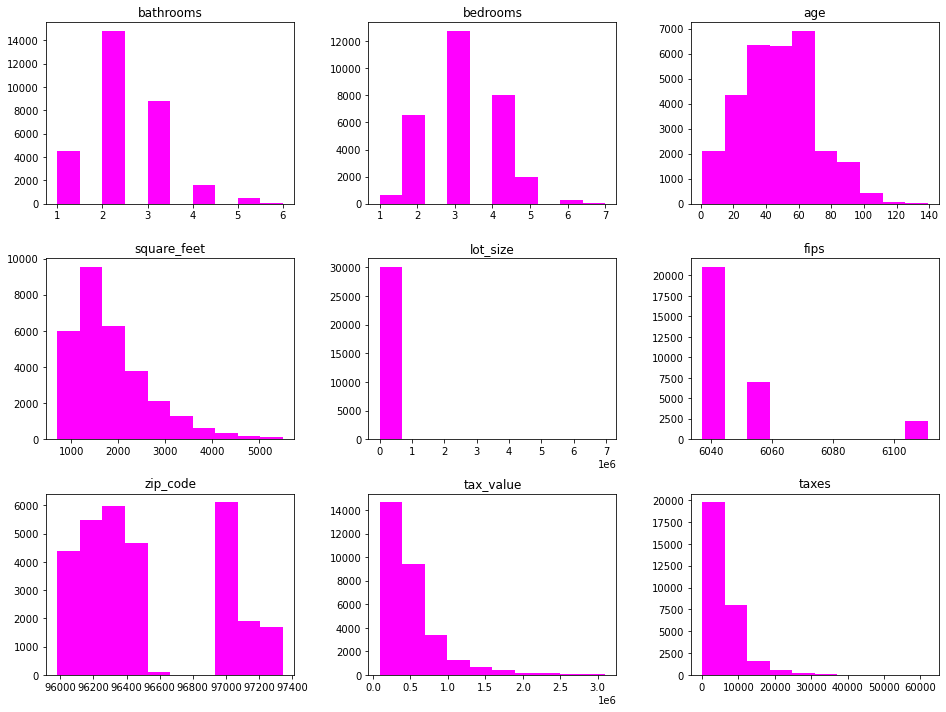

In [30]:
#Exploring distribution of all numeric columns in entire df

df.hist(grid=False, figsize=(16,12), color='magenta')

In [31]:
df.age.median()

48.0

#### ```Takeaways:```
- Explorations done on unscaled data to check distribution of data.
- Majority of properties in FIPS 6040
- Zip codes are appropriate for area.
- Square footage is right skewed, with the majority of observations between ~1000 and 2500 square feet.
- Bedroom and bathroom counts have a normall distribution
- Age of homes is right skewed. Majority of homes < 60 years.

<AxesSubplot:xlabel='fips', ylabel='Density'>

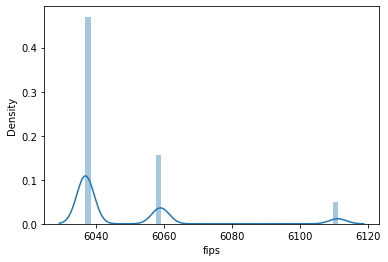

In [32]:
#Create a distplot to explore the distribution of Pandas Series

sns.distplot(df.fips)

#### ```Takeaways:```
- Majority of properties are in FIPS 6040 - Los Angeles County.
- Properties in Ventura County (6111) are by far the smallest set.

<AxesSubplot:>

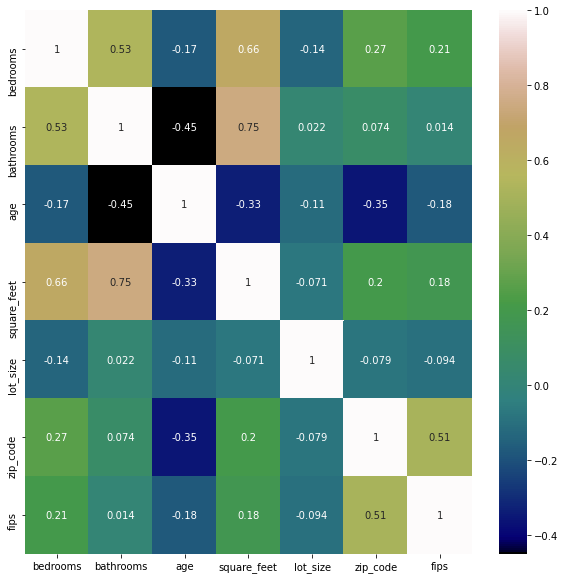

In [33]:
# Create heatmap to look for correlations between variables
plt.subplots(figsize=(10,10))
sns.heatmap(X_train_scaled.corr(), cmap='gist_earth',annot=True)

#### ```Takeaways:```
- Heatmap was prepared on scaled data
- High correlation between: bathrooms/square_feet, bedroom/bathroom, bedrooms/square feet 
- Low/no association between: lot_size/county or zip_code, age/county, lot_size/square_feet, zip_code/square_feet

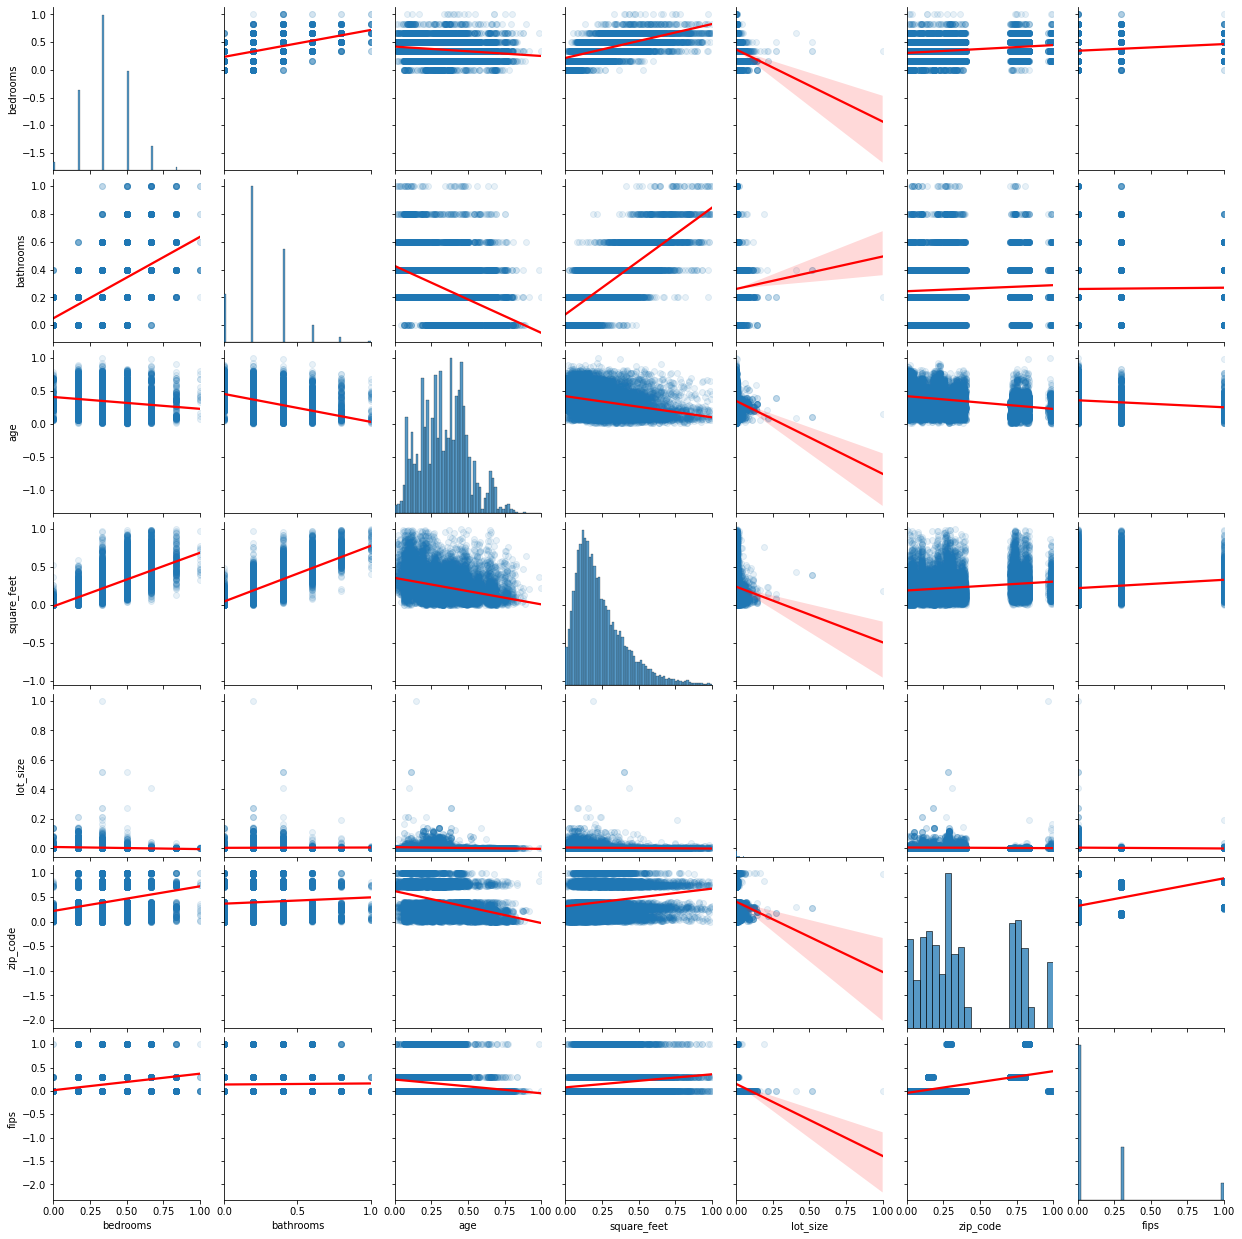

In [34]:
# Create pair plot to look at how each variable relates to other individual variables
plot_kws={'line_kws':{'color':'red'},'scatter_kws': {'alpha': 0.7}}    
sns.pairplot(X_train_scaled, kind="reg", plot_kws={'line_kws':{'color':'red'},'scatter_kws': {'alpha': 0.1} })


```Takeaways:```
- Since we are comparing variables of different units, we are using scaled data.
- High correlation between: bathrooms/square_feet, bedroom/bathroom, bedrooms/square feet 
- Low/no association between: lot_size/county or zip_code, age/county, lot_size/square_feet, zip_code/square_feet

The p-value is: 0.0. There is 0.0% chance that we see these results by chance.
r = 0.53


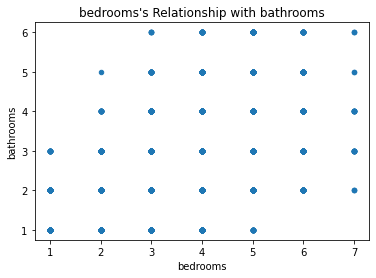

In [36]:
def correlation_exploration(train, x_string, y_string):
    '''
    This function takes in a df, a string for an x-axis variable in the df, 
    and a string for a y-axis variable in the df and displays a scatter plot, the r-
    squared value, and the p-value. It explores the correlation between input the x 
    and y variables.
    '''
    r, p = stats.pearsonr(train[x_string], train[y_string])
    df.plot.scatter(x_string, y_string)
    plt.title(f"{x_string}'s Relationship with {y_string}")
    print(f'The p-value is: {p}. There is {round(p,3)}% chance that we see these results by chance.')
    print(f'r = {round(r, 2)}')
    plt.show()

correlation_exploration(X_train_scaled, 'bedrooms', 'bathrooms')

The p-value is: 2.6491141113499226e-294. There is 0.0% chance that we see these results by chance.
r = 0.28


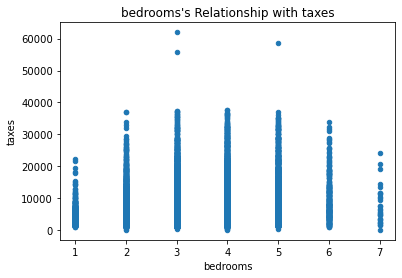

In [37]:
correlation_exploration(X_train, 'bedrooms', 'taxes')

The p-value is: 3.739425368089971e-21. There is 0.0% chance that we see these results by chance.
r = -0.07


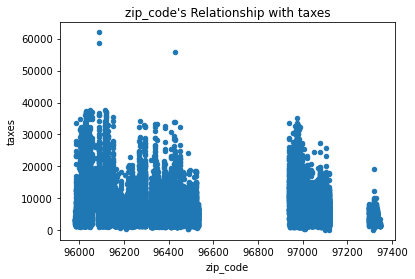

In [38]:
correlation_exploration(X_train, 'zip_code', 'taxes')

The p-value is: 0.0015609357743409356. There is 0.002% chance that we see these results by chance.
r = 0.02


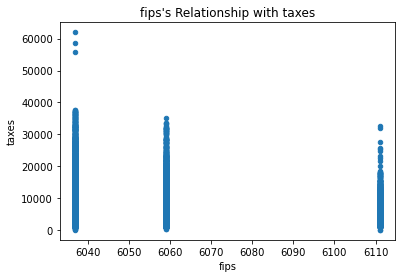

In [39]:
correlation_exploration(X_train, 'fips', 'taxes')

The p-value is: 1.3282308202057336e-78. There is 0.0% chance that we see these results by chance.
r = -0.14


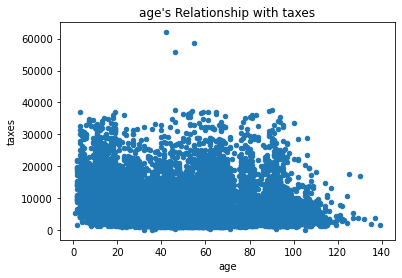

In [40]:
correlation_exploration(X_train, 'age', 'taxes')

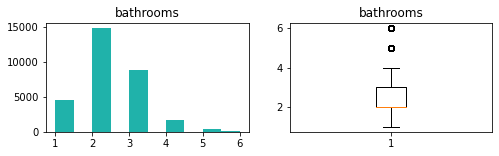

count   30259.000
mean        2.309
std         0.865
min         1.000
25%         2.000
50%         2.000
75%         3.000
max         6.000
Name: bathrooms, dtype: float64


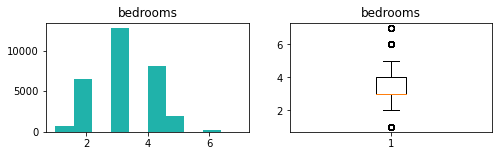

count   30259.000
mean        3.167
std         0.947
min         1.000
25%         3.000
50%         3.000
75%         4.000
max         7.000
Name: bedrooms, dtype: float64


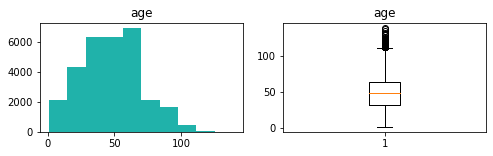

count   30259.000
mean       48.126
std        22.481
min         1.000
25%        31.000
50%        48.000
75%        63.000
max       139.000
Name: age, dtype: float64


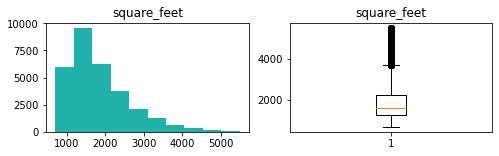

count   30259.000
mean     1843.995
std       811.673
min       700.000
25%      1254.000
50%      1638.000
75%      2240.000
max      5496.000
Name: square_feet, dtype: float64


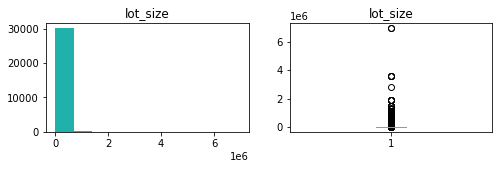

count     30259.000
mean      30609.348
std      114494.717
min         236.000
25%        5854.500
50%        7380.000
75%       12455.500
max     6971010.000
Name: lot_size, dtype: float64


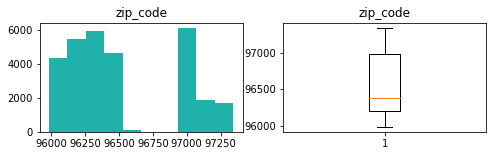

count   30259.000
mean    96524.673
std       404.214
min     95982.000
25%     96204.000
50%     96383.000
75%     96982.000
max     97344.000
Name: zip_code, dtype: float64


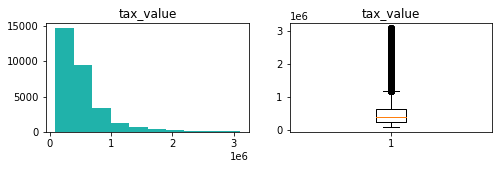

count     30259.000
mean     506419.954
std      399716.440
min       90035.000
25%      248916.000
50%      400941.000
75%      624139.000
max     3100000.000
Name: tax_value, dtype: float64


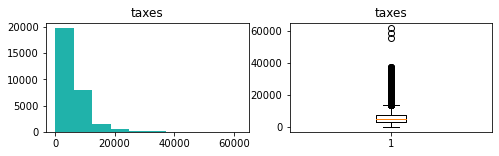

count   30259.000
mean     6183.252
std      4651.652
min        62.440
25%      3256.365
50%      4944.940
75%      7460.365
max     61992.630
Name: taxes, dtype: float64


In [41]:
# def plot_cat_by_target(train, target, cat_var):
#     p = plt.figure(figsize=(8,8))
#     p = sns.barplot(cat_var, target, data=train, alpha=.8, color='lightseagreen')
#     overall_rate = train[target].mean()
#     p = plt.axhline(overall_rate, ls='--', color='gray')
#     return p 

# plot_cat_by_target(df, df.tax_value, df.bedrooms)
cat_vars = []
quant_vars = ['bathrooms', 'bedrooms', 'age', 'square_feet', 'lot_size', 'zip_code', 'tax_value', 'taxes']
def explore_univariate_quant(train, quant_var):
    '''
    takes in a dataframe and a quantitative variable and returns
    descriptive stats table, histogram, and boxplot of the distributions. 
    '''
    descriptive_stats = train[quant_var].describe()
    plt.figure(figsize=(8,2))

    p = plt.subplot(1, 2, 1)
    p = plt.hist(train[quant_var], color='lightseagreen')
    p = plt.title(quant_var)

    # second plot: box plot
    p = plt.subplot(1, 2, 2)
    p = plt.boxplot(train[quant_var])
    p = plt.title(quant_var)
    return p, descriptive_stats

def explore_univariate(train, cat_vars, quant_vars):
    for var in cat_vars:
        explore_univariate_categorical(train, var)
        print('_________________________________________________________________')
    for col in quant_vars:
        p, descriptive_stats = explore_univariate_quant(train, col)
        plt.show(p)
        print(descriptive_stats)
        
explore_univariate(df, cat_vars, quant_vars)

<a id='HypoCorr'></a>
### ```Hypothesis Testing - Correlation #1 - County/Tax Value: ```
    
#### Does the county a home is located in affect the tax value?

- H$_{0}$: There is no relationship between the county is located in and its tax value.  --> <font color = 'red'> **REJECTED**<font color = 'black'>

- H$_{a}$: There is a dependent relationship between county and tax value.  

#### Takeaways: 
- The 'r' correlation coefficient is 0.06468945085502781
- The p-value (probability of seeing the data given the null hypothesis is true) is  3.492977794581021e-17

**Therefore, we reject the null hypothesis that there is no relationship between county and tax value.**

In [42]:
α = .05

x = X_train.fips
y = y_train.tax_value

r, p = stats.pearsonr(x,y)


print("'r' correlation coefficient is", r)
print("p-value (probability of seeing the data given the null hypothesis is true) is ", p)

if p < α:
    print("We reject the null hypothesis that there is no relationship between county and tax value.")
else:
    print("We fail to reject the null hypothesis")


'r' correlation coefficient is 0.06468945085502781
p-value (probability of seeing the data given the null hypothesis is true) is  3.492977794581021e-17
We reject the null hypothesis that there is no relationship between county and tax value.


### ```Hypothesis Testing - Correlation #2 - Lot Size/Tax Value: ```
    
#### Does the size of the lot a home is located on affect the tax value?

- H$_{0}$: There is no relationship between the size of the lot a home is located on and its tax value.  --> <font color = 'red'> **REJECTED**<font color = 'black'>

- H$_{a}$: There is a relationship between lot size and tax value.  

#### Takeaways: 
- The 'r' correlation coefficient is -0.057867045752652856
- The p-value (probability of seeing the data given the null hypothesis is true) is  4.76270361809467e-14

**Therefore, we reject the null hypothesis that there is no relationship between lot_size and tax value.**

In [43]:
α = .05

x3 = X_train.lot_size
y = y_train.tax_value

r, p = stats.pearsonr(x3,y)


print("'r' correlation coefficient is", r)
print("p-value (probability of seeing the data given the null hypothesis is true) is ", p)

if p < α:
    print("We reject the null hypothesis that there is no relationship between lot_size and tax value.")
else:
    print("We fail to reject the null hypothesis")


'r' correlation coefficient is -0.057867045752652856
p-value (probability of seeing the data given the null hypothesis is true) is  4.76270361809467e-14
We reject the null hypothesis that there is no relationship between lot_size and tax value.


<a id='HypoTt'></a>
### ```Hypothesis Testing - T-Test #1 - County/Tax Value:```

#### Does the county that a home is located in affect its tax value?**

- H$_{0}$: There is no difference in mean tax value between homes in Los Angeles County and the remainder of the counties.--> <font color = 'red'>**REJECTED** <font color = 'black'>
    
- H$_{a}$: There is a difference in mean tax value between homes in Los Angeles County and the remainder of the counties.  

#### Takeaways: 
- The t-stat is: -22.463860331538726, the p-value is: 7.568156691971651e-111.
- We reject the null hypothesis that there is no difference in mean tax value between homes in Los Angeles County and the remainder of the counties.
- We move forward with the alternative hypothesis.

In [44]:
x1a = df[df.fips == 6037].tax_value
x2a = df[df.fips != 6037].tax_value

confidence_level = 0.95
a = 0.5

t, p = stats.ttest_ind(x1a, x2a)
t,p


if p < a:
    print (f'The t-stat is: {t}, the p-value is: {p}.')
    print("We reject the null hypothesis that they are the same")
    print("We move forward with the alternative hypothesis.")
else: 
    print(f'The t-stat is: {t}, the p-value is: {p}.')
    print("We fail to reject the null hypothesis that there is no difference in tax value of a home based on an age over 30 years.")


The t-stat is: -22.463860331538726, the p-value is: 7.568156691971651e-111.
We reject the null hypothesis that they are the same
We move forward with the alternative hypothesis.


### ```Hypothesis Testing - T-Test - Age/Tax Value: ```
    
**Does the age of a home affect its tax value?**

- H$_{0}$: There is no difference between the mean tax value of a home that is over 30 years old and one that is under 30.  --> <font color = 'red'>**REJECTED** <font color = 'black'>
    
- H$_{a}$: There is a difference in mean tax value of a home based on its age.  


### Takeaways: 
- The t-stat is: 36.46646257972798, the p-value is: 36.46646257972798.
- **We reject the null hypothesis that there is no difference in tax value of a home based on an age over 30 years.**
- We move forward with the alternative hypothesis.



In [45]:
x1 = df[df.age < 30].tax_value
x2 = df[df.age >= 30].tax_value

confidence_level = 0.95
a = 0.5

t, p = stats.ttest_ind(x1, x2)
t,p

if p < a:
    print (f'The t-stat is: {t}, the p-value is: {p}.')
    print("We reject the null hypothesis that they are the same")
    print("We move forward with the alternative hypothesis.")
else: 
#   print (f'The t-stat is: {t}, the p-value is: {p}.')
    print("We fail to reject the null hypothesis that there is no difference in tax value of a home based on an age over 30 years.")

The t-stat is: 36.46646257972798, the p-value is: 5.644500960279063e-285.
We reject the null hypothesis that they are the same
We move forward with the alternative hypothesis.


<a id='Baseline'></a>
### ```Create a Baseline```

#### Takeaways:
- Mean and median tax values were evaluated for error using Root Mean Squared Error.  
- The mean tax value had a smaller error value, therefore, I choose to use the mean of tax values as a baseline for modeling.
- Our baseline value for modeling is $505,045.81

RMSE using Mean Baseline
Train/In-Sample:   398280.82 
Validate/Out-of-Sample:   402221.78
RMSE using Median Baseline
Train/In-Sample:   412156.92 
Validate/Out-of-Sample:   416300.83

In [46]:
# Create dataframes of y_train and y_validate , so we can append new columns with predicted values
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# Predict mean
y_pred_mean = y_train['tax_value'].mean()
y_train['y_pred_mean'] = y_pred_mean
y_validate['y_pred_mean']= y_pred_mean


# Predict mean
y_pred_median = y_train['tax_value'].median()
y_train['y_pred_median'] = y_pred_median
y_validate['y_pred_median']= y_pred_median


y_train.head()

# # Make a copy of y_train dataframe, named ols_eval, with renamed column for actual value

ols_eval = y_train.copy()
ols_eval.head()



,tax_value,y_pred_mean,y_pred_median
parcel_id,,,
11640078,475281.000,505045.807,399000.000
10728405,605000.000,505045.807,399000.000
17239776,542864.000,505045.807,399000.000
11473641,120656.000,505045.807,399000.000
12551066,234048.000,505045.807,399000.000


In [47]:
# Find RMSE of IM_pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.y_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.y_pred_mean)**(1/2)

print("RMSE using Mean Baseline\nTrain/In-Sample:  ", round(rmse_train, 2),
     "\nValidate/Out-of-Sample:  ", round(rmse_validate, 2,))

# Find RMSE of IM_pred_median
rmse_train = mean_squared_error(y_train.tax_value, y_train.y_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.y_pred_median)**(1/2)

print("RMSE using Median Baseline\nTrain/In-Sample:  ", round(rmse_train, 2),
     "\nValidate/Out-of-Sample:  ", round(rmse_validate, 2))

RMSE using Mean Baseline
Train/In-Sample:   398280.82 
Validate/Out-of-Sample:   402221.78
RMSE using Median Baseline
Train/In-Sample:   412156.92 
Validate/Out-of-Sample:   416300.83


#### Adding the mean tax value to the y-dataframe as baseline/yhat:

In [48]:
ols_eval.rename(columns = {'tax_value':'actual', 'y_pred_mean':'baseline_yhat'}, inplace=True)
ols_eval = ols_eval.drop(columns=['y_pred_median'])
ols_eval.head()

,actual,baseline_yhat
parcel_id,,
11640078,475281.000,505045.807
10728405,605000.000,505045.807
17239776,542864.000,505045.807
11473641,120656.000,505045.807
12551066,234048.000,505045.807


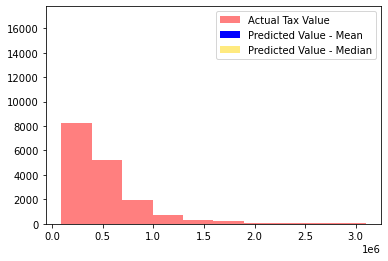

In [49]:
# plot to visualize actual v. predicted
# plot to visualize actual v. predicted

plt.hist(y_train.tax_value, color = 'red', alpha = .5, label = "Actual Tax Value")
plt.hist(y_train.y_pred_mean, bins=7, color = 'blue', rwidth=100, label = "Predicted Value - Mean")
plt.hist(y_train.y_pred_median, bins=7, color = 'gold', alpha = .5, rwidth=100, label = "Predicted Value - Median")
plt.legend()
plt.show()


<a id='Model'></a>
### ```Model Data - Explore```

```Takeaways from Modeling:```

####  Ordinary Lease Squares (OLS) Model

In [52]:
# make the model
lm = LinearRegression(normalize=True)

#fit the model to training data. 
lm.fit(X_train_scaled, y_train.tax_value)

#predict train
y_train['tax_value_pred_lm'] = lm.predict(X_train_scaled)

In [53]:
#evaluate: RMSE
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm)**(1/2)

#predict validate
y_validate['tax_value_pred_lm'] = lm.predict(X_validate_scaled)

# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining In-Sample:  ", rmse_train, "\nValidation/Out-of-Sample:  ", rmse_validate)
print("  ")
print("Baseline RMSE using Mean ", "\nTrain/In-Sample:   398280.82", "\nValidate/Out-of-Sample:   402221.78")

RMSE for OLS using LinearRegression
Training In-Sample:   315829.64771309856 
Validation/Out-of-Sample:   317944.22022041975
  
Baseline RMSE using Mean  
Train/In-Sample:   398280.82 
Validate/Out-of-Sample:   402221.78


In [54]:
#calculate R-squared value
r_ols = r2_score(y_train.tax_value, y_train.tax_value_pred_lm)
print(f"R^2 for OLS Model = {r_ols}")

R^2 for OLS Model = 0.371179057231505


####  LassoLars Model

In [55]:
#create the model
lars = LassoLars(alpha = 1.0)

#fit the model to training data
lars.fit(X_train_scaled, y_train.tax_value)

#predict train
y_train['tax_value_pred_lars'] = lars.predict(X_train_scaled)

#evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value,y_train.tax_value_pred_lars)**(1/2)

#predict validate
y_validate['tax_value_pred_lars'] = lars.predict(X_validate_scaled)

#evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value,y_validate.tax_value_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining\In-Sample:  ", rmse_train, "\nValidation/Out-of-Sample:  ", rmse_validate)
print("  ")
print("Baseline RMSE using Mean ", "\nTrain/In-Sample:   398280.82", "\nValidate/Out-of-Sample:   402221.78")

RMSE for Lasso + Lars
Training\In-Sample:   315830.0267456726 
Validation/Out-of-Sample:   317951.08368831535
  
Baseline RMSE using Mean  
Train/In-Sample:   398280.82 
Validate/Out-of-Sample:   402221.78


In [56]:
#calculate R-squared value
r_lars = r2_score(y_train.tax_value, y_train.tax_value_pred_lars)
print(f"R^2 for LassoLars Model = {r_lars}")

R^2 for LassoLars Model = 0.3711775479130145


#### TweedieRegressor (GLM - Generalized Linear Model)

In [57]:
#create the model object
glm = TweedieRegressor(power=1, alpha=0)

#fit the model to training data
glm.fit(X_train_scaled,y_train.tax_value)

#predict train
y_train['tax_value_pred_glm']=glm.predict(X_train_scaled)

#evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value,y_train.tax_value_pred_glm)**(1/2)

#predict validate
y_validate['tax_value_pred_glm']=glm.predict(X_validate_scaled)

#evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value,y_validate.tax_value_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power = 1 & alpha = 0\nTraining/In-Sample:  ", rmse_train, "\nValidation/Out-of-Sample:  ", rmse_validate)
print("  ")
print("Baseline RMSE using Mean ", "\nTrain/In-Sample:   398280.82", "\nValidate/Out-of-Sample:   402221.78")

RMSE for GLM using Tweedie, power = 1 & alpha = 0
Training/In-Sample:   319254.9152606865 
Validation/Out-of-Sample:   319824.04540014896
  
Baseline RMSE using Mean  
Train/In-Sample:   398280.82 
Validate/Out-of-Sample:   402221.78


In [58]:
#calculate R-squared value
r_glm = r2_score(y_train.tax_value, y_train.tax_value_pred_glm)
print(f"R^2 for TweedieRegressor / Generalized Linear Model = {r_glm}")

R^2 for TweedieRegressor / Generalized Linear Model = 0.3574655903526446


### Polynomial Regression - Create Polynomial Features, Then Linear Regression

In [59]:
# make the polynomial fetures to get a new set of features
pf = PolynomialFeatures(degree=2)

#fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

#transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 = pf.transform(X_test_scaled)

# make the model
lm2 = LinearRegression(normalize=True)

#fit the model to training data. 
lm2.fit(X_train_degree2, y_train.tax_value)

#predict train
y_train['tax_value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: RMSE
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm2)**(1/2)

#predict validate
y_validate['tax_value_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining In-Sample:  ", rmse_train, "\nValidation/Out-of-Sample:  ", rmse_validate)
print("  ")
print("Baseline RMSE using Mean ", "\nTrain/In-Sample:   398280.82", "\nValidate/Out-of-Sample:   402221.78")

RMSE for Polynomial Model, degrees=2
Training In-Sample:   303548.2524948342 
Validation/Out-of-Sample:   304596.6650769751
  
Baseline RMSE using Mean  
Train/In-Sample:   398280.82 
Validate/Out-of-Sample:   402221.78


In [60]:
#calculate R-squared value
r_prm = r2_score(y_train.tax_value, y_train.tax_value_pred_lars)
print(f"R^2 for Polynomial Regression Model = {r_prm}")

R^2 for Polynomial Regression Model = 0.3711775479130145


<a id='Feature'></a>
### ```Feature Engineering```

### ```Takeaways:```
- The five best predictors, according to **k best** are: bedrooms, bathrooms, age, square feet and county.
- The five best predictors, according to **recursive feature elimination** are: bedrooms, bathrooms, square feet, lot size, and zip code. 

    
<font color = 'green'> **I will use the following features to select the best model: Bathrooms, Age of Home, Square Feet, Zip Code**



In [61]:
# cleaned up y_train
y_train = y_train.drop(columns=['y_pred_median', 'y_pred_mean', "tax_value_pred_lm"])
y_train.head()

,tax_value,tax_value_pred_lars,tax_value_pred_glm,tax_value_pred_lm2
parcel_id,,,,
11640078,475281.000,1213008.410,1381808.886,1677163.601
10728405,605000.000,410234.147,407809.461,365010.917
17239776,542864.000,435780.909,421591.981,361595.721
11473641,120656.000,514764.849,479987.895,504671.620
12551066,234048.000,375898.528,390583.705,359513.309


In [62]:
# X_train_scaled = X_train_scaled.drop(columns=['taxes'])
X_train_scaled.head()

,bedrooms,bathrooms,age,square_feet,lot_size,zip_code,fips
11640078,0.500,1.000,0.464,0.608,0.004,0.076,0.000
10728405,0.333,0.200,0.406,0.160,0.001,0.264,0.000
17239776,0.333,0.200,0.377,0.192,0.001,0.833,1.000
11473641,0.333,0.200,0.529,0.193,0.001,0.089,0.000
12551066,0.333,0.200,0.457,0.122,0.000,0.193,0.000


In [63]:
y_train.head()

,tax_value,tax_value_pred_lars,tax_value_pred_glm,tax_value_pred_lm2
parcel_id,,,,
11640078,475281.000,1213008.410,1381808.886,1677163.601
10728405,605000.000,410234.147,407809.461,365010.917
17239776,542864.000,435780.909,421591.981,361595.721
11473641,120656.000,514764.849,479987.895,504671.620
12551066,234048.000,375898.528,390583.705,359513.309


In [64]:
from sklearn.feature_selection import SelectKBest, f_regression

# parameters: f_regression stats test, give me 5 features
f_selector = SelectKBest(f_regression, k=5)

# drop additional columns in y_train
y_train_org = y_train.drop(columns = ["tax_value_pred_lars", "tax_value_pred_glm", "tax_value_pred_lm2"])

# find the top 2 X's correlated with y
f_selector.fit(X_train_scaled, y_train_org)

# boolean mask of whether the column was selected or not. 
#get_support() produces an array of booleans, so we can filter out the column names that matter the most
feature_mask = f_selector.get_support()

# get list of top 2 features. 
f_feature = X_validate_scaled.iloc[:,feature_mask].columns.tolist()
f_feature
print(f'The five best predictors, according to k best are: {f_feature}.')

The five best predictors, according to k best are: ['bedrooms', 'bathrooms', 'age', 'square_feet', 'fips'].


In [65]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, 5)

# fit the data using RFE
rfe.fit(X_train_scaled,y_train)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

rfe_feature
print(f'The five best predictors, according to recursive feature elimination are: {rfe_feature}.')

The five best predictors, according to recursive feature elimination are: ['bedrooms', 'bathrooms', 'square_feet', 'lot_size', 'zip_code'].


# Rerun all models using Engineered Features

### ```Takeaways using Engineered Features:```

**Modeling on Engineered Features:**
- Bathrooms, Age of Home, Square Feet, Zip Code
- All models beat baseline
- **Polynomial Regression (degree of 2) had the smallest error**

- **Use Polynomial Regression (degree of 2) to predict values on test data.**

**Comparing RMSE on Validate (Out-of-Sample) Data Set with Engineered Features**

<font color = 'blue'>**402221.78 = Baseline RMSE using Mean** 

<font color = 'green'>**316093.75 = Polynomial Regression, Degree of 2**
    
322795.49 = GLM using Tweedie Regressor
    
323047.03 = OLS using LinearRegression
    
323050.96 = Lasso + Lars
    

In [66]:
X_train_scaled.head()
X_train_fe = X_train_scaled.drop(columns=['fips','bedrooms','lot_size'])
X_validate_fe = X_validate_scaled.drop(columns=['fips', 'bedrooms','lot_size'])
X_test_fe = X_test_scaled.drop(columns=['fips', 'bedrooms','lot_size'])
X_test_final = X_test.drop(columns=['fips', 'bedrooms','lot_size'])

####  ```Ordinary Lease Squares (OLS) Model after Feature Engineering```

In [67]:
# make the model
lm = LinearRegression(normalize=True)

#fit the model to training data. 
lm.fit(X_train_fe, y_train.tax_value)

#predict train
y_train['tax_value_pred_lm'] = lm.predict(X_train_fe)

In [68]:
#predict train
y_train['tax_value_pred_lm'] = lm.predict(X_train_fe)

#evaluate: RMSE
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm)**(1/2)

#predict validate
y_validate['tax_value_pred_lm'] = lm.predict(X_validate_fe)

# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining In-Sample after Feature Engineering:  ", rmse_train, "\nValidation/Out-of-Sample after Feature Engineering:  ", rmse_validate)
print("  ")
print("Baseline RMSE using Mean ", "\nTrain/In-Sample:   398280.82", "\nValidate/Out-of-Sample:   402221.78")

RMSE for OLS using LinearRegression
Training In-Sample after Feature Engineering:   320456.31984663004 
Validation/Out-of-Sample after Feature Engineering:   323047.0301683315
  
Baseline RMSE using Mean  
Train/In-Sample:   398280.82 
Validate/Out-of-Sample:   402221.78


In [69]:
#calculate R-squared value
r_ols = r2_score(y_train.tax_value, y_train.tax_value_pred_lm)
print(f"R^2 for OLS Model after Feature Engineering = {r_ols}")

R^2 for OLS Model after Feature Engineering = 0.3526205826795683


####  ```LassoLars Model after Feature Engineering```

In [70]:
#create the model
lars = LassoLars(alpha = 1.0)

#fit the model to training data
lars.fit(X_train_fe, y_train.tax_value)

#predict train
y_train['tax_value_pred_lars'] = lars.predict(X_train_fe)

#evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value,y_train.tax_value_pred_lars)**(1/2)

#predict validate
y_validate['tax_value_pred_lars'] = lars.predict(X_validate_fe)

#evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value,y_validate.tax_value_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining\In-Sample after Feature Engineering:  ", rmse_train, "\nValidation/Out-of-Sample after Feature Engineering:  ", rmse_validate)
print("  ")
print("Baseline RMSE using Mean ", "\nTrain/In-Sample:   398280.82", "\nValidate/Out-of-Sample:   402221.78")

RMSE for Lasso + Lars
Training\In-Sample after Feature Engineering:   320456.430274938 
Validation/Out-of-Sample after Feature Engineering:   323050.96145580575
  
Baseline RMSE using Mean  
Train/In-Sample:   398280.82 
Validate/Out-of-Sample:   402221.78


In [71]:
#calculate R-squared value
r_lars = r2_score(y_train.tax_value, y_train.tax_value_pred_lars)
print(f"R^2 for LassoLars Model after Feature Engineering = {r_lars}")

R^2 for LassoLars Model after Feature Engineering = 0.3526201365093944


#### ```TweedieRegressor (GLM - Generalized Linear Model) after Feature Engineering```

In [72]:
#create the model object
glm = TweedieRegressor(power=1, alpha=.5)

#fit the model to training data
glm.fit(X_train_fe,y_train.tax_value)

#predict train
y_train['tax_value_pred_glm']=glm.predict(X_train_fe)

#evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value,y_train.tax_value_pred_glm)**(1/2)

#predict validate
y_validate['tax_value_pred_glm']=glm.predict(X_validate_fe)

#evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value,y_validate.tax_value_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power = 1 & alpha = 0\nTraining/In-Sample after Feature Engineering:  ", rmse_train, "\nValidation/Out-of-Sample after Feature Engineering:  ", rmse_validate)
print("  ")
print("Baseline RMSE using Mean ", "\nTrain/In-Sample:   398280.82", "\nValidate/Out-of-Sample:   402221.78")

RMSE for GLM using Tweedie, power = 1 & alpha = 0
Training/In-Sample after Feature Engineering:   321999.60182000115 
Validation/Out-of-Sample after Feature Engineering:   322795.49413647124
  
Baseline RMSE using Mean  
Train/In-Sample:   398280.82 
Validate/Out-of-Sample:   402221.78


In [73]:
#calculate R-squared value
r_glm = r2_score(y_train.tax_value, y_train.tax_value_pred_glm)
print(f"R^2 for TweedieRegressor / Generalized Linear Model after Feature Engineering = {r_glm}")

R^2 for TweedieRegressor / Generalized Linear Model after Feature Engineering = 0.3463701536922845


### ```Polynomial Regression Model after Feature Engineering - Create Polynomial Features, Then Linear Regression```

In [74]:
# make the polynomial fetures to get a new set of features
pf = PolynomialFeatures(degree=2)

#fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_fe)

#transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_fe)
X_test_degree2 = pf.transform(X_test_fe)

# make the model
lm2 = LinearRegression(normalize=True)

#fit the model to training data. 
lm2.fit(X_train_degree2, y_train.tax_value)

#predict train
y_train['tax_value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: RMSE
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm2)**(1/2)

#predict validate
y_validate['tax_value_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining In-Sample after Feature Engineering:  ", rmse_train, "\nValidation/Out-of-Sample after Feature Engineering:  ", rmse_validate)
print("  ")
print("Baseline RMSE using Mean ", "\nTrain/In-Sample:   398280.82", "\nValidate/Out-of-Sample:   402221.78")

RMSE for Polynomial Model, degrees=2
Training In-Sample after Feature Engineering:   314806.81569003756 
Validation/Out-of-Sample after Feature Engineering:   316093.75115403073
  
Baseline RMSE using Mean  
Train/In-Sample:   398280.82 
Validate/Out-of-Sample:   402221.78


In [75]:
#calculate R-squared value
r_prm = r2_score(y_train.tax_value, y_train.tax_value_pred_lars)
print(f"R^2 for Polynomial Regression Model after Feature Engineering= {r_prm}")

R^2 for Polynomial Regression Model after Feature Engineering= 0.3526201365093944


<a id='Test'></a>
### ```Modeling on the Test Data Set```

In [76]:
# verify we are using the same, scaled and engineered features as were used on train and validate models
X_test_fe.head()

,bathrooms,age,square_feet,zip_code
14383004,0.200,0.283,0.535,0.726
12121210,0.000,0.630,0.101,0.230
12548132,0.200,0.196,0.127,0.186
11089278,0.400,0.406,0.356,0.274
10795677,0.200,0.428,0.206,0.299


### ```Polynomial Regression Model on Test (degree of 2) Data```

#### ```Takeaways from Evaluating Test Data on RMSE for Polynomial Model, degrees=2```

RMSE of Test/Out-of-Sample after Feature Engineering:   316093.75
  
Baseline RMSE using Mean: 402221.78

**Our model performs better than baseline and can be used to predict home values based on bathroom count, age of home, square footage and zip code.**

In [77]:
# make the polynomial fetures to get a new set of features
pf = PolynomialFeatures(degree=2)

#fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_fe)

#transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_fe)
X_test_degree2 = pf.transform(X_test_fe)


# make the model
lm2 = LinearRegression(normalize=True)

#fit the model to training data. 
lm2a = lm2.fit(X_train_degree2, y_train.tax_value)

#predict test
y_test['tax_value_pred_lm2'] = lm2a.predict(X_test_degree2)

# evaluate: RMSE
rmse_test = mean_squared_error(y_test.tax_value, y_test.tax_value_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTest/Out-of-Sample after Feature Engineering:  ", rmse_validate)
print("  ")
print("Baseline RMSE using Mean ", "\nTest/Out-of-Sample:   402221.78")

RMSE for Polynomial Model, degrees=2
Test/Out-of-Sample after Feature Engineering:   316093.75115403073
  
Baseline RMSE using Mean  
Test/Out-of-Sample:   402221.78


<a id='Visual'></a>
### ```Final Model Visualizations```

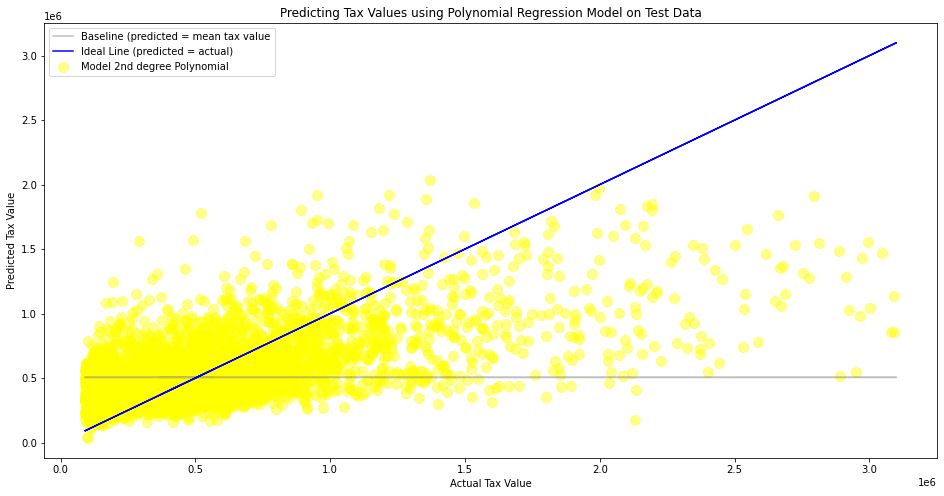

In [78]:
plt.figure(figsize=(16,8))
plt.plot(y_validate.tax_value, y_validate.y_pred_mean, alpha=.5, color="gray", label='Baseline (predicted = mean tax value')
plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=.999, color="blue", label='Ideal Line (predicted = actual)')
# plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm, 
#             alpha=.75, color="red", s=100, label="Model: LinearRegression")
# plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_glm, 
#             alpha=.25, color="blue", s=100, label="Model: TweedieRegressor")
plt.scatter(y_test.tax_value, y_test.tax_value_pred_lm2, 
            alpha=.45, color="yellow", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.title("Predicting Tax Values using Polynomial Regression Model on Test Data")
plt.show()

### ```Takeaways:```
The scatterplot demonstrates that our model tends to under-value homes that exceed the median tax value of ~$408,000.

In [79]:
# Check for median tax value (because it should ~ 1.5 scaled value)
y_test.tax_value.median()

407557.5

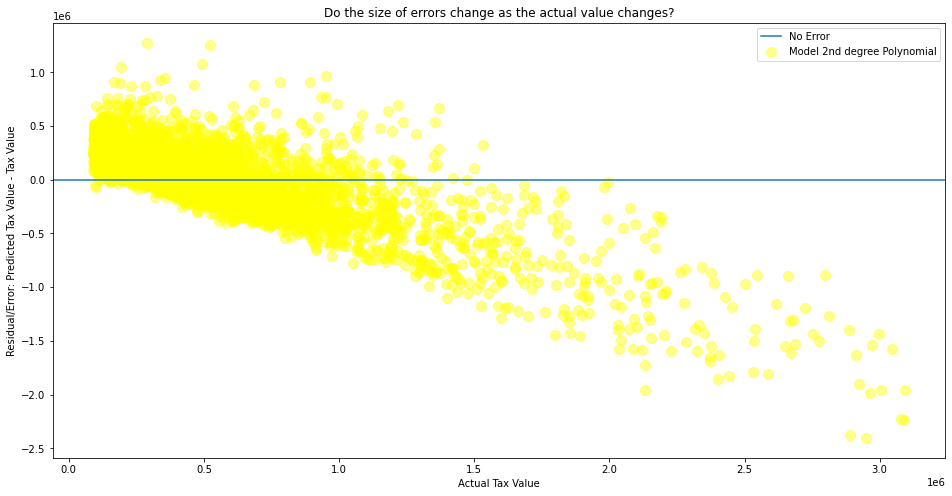

In [80]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_test.tax_value, y_test.tax_value_pred_lm2 - y_test.tax_value, 
            alpha=.45, color="yellow", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Residual/Error: Predicted Tax Value - Tax Value")
plt.title("Do the size of errors change as the actual value changes?")
plt.show()

In [81]:

y_test['errors'] = (y_test.tax_value_pred_lm2 - y_test.tax_value)
y_test

,tax_value,tax_value_pred_lm2,errors
parcel_id,,,
14383004,673097.000,814394.455,141297.455
12121210,179190.000,393283.430,214093.430
12548132,665144.000,383719.339,-281424.661
11089278,163714.000,652049.835,488335.835
10795677,246828.000,442847.683,196019.683
...,...,...,...
17224893,920959.000,1500363.415,579404.415
13085759,370734.000,397794.392,27060.392
14015760,133624.000,352380.406,218756.406


# ```Distribution of Tax Rates by County```

In [82]:
# created a new data frame to calculate tax distribution
tax_rates = df

In [83]:
# removing outliers in tax rates

def remove_tax_value_outliers(df):
    # Calculate the interquartile range for your column

    q1, q3 = df.tax_value.quantile([.25, .75])
    
    iqr = q3 - q1
    
    # Create variables holding upper and lower cutoff values using common formula. Tweak as you like.
    
    tax_upperbound = q3 + 3.5 * iqr
    
    #tax_lowerbound = q1 - 3 * iqr ==> The lowerbound is negative and since there are no negative values, 
    # there are no lowerbound outliers
    
    # Filter the column using variables and reassign to your dataframe.
    tax_dist_a = tax_rates[tax_rates.tax_value < tax_upperbound]
    return tax_dist_a


#regenerate tax rates without outliers
tax_rates = remove_tax_value_outliers(tax_rates)
tax_rates = tax_rates.drop(columns = ['bathrooms','bedrooms','age','square_feet','lot_size', 'zip_code'])
tax_rates.head(1)

,fips,tax_value,taxes
parcel_id,,,
11721753,6037,205123.000,2627.480


### ```Takeaways for data set: ```
- Data was adjusted for outliers using IQR 
- The mean tax rate of all 29,754 observations in our sample is 1.276%
- The median tax rate is 1.22%. (The 50th percentile)
- The minimum tax rate is 0.010% and the maximum is 18.26%

In [84]:
# create a column that displays calculated tax rate for each observation 
tax_rates['tax_rate'] = round(((tax_rates.taxes / tax_rates.tax_value) * 100),2)
tax_rates.head()

,fips,tax_value,taxes,tax_rate
parcel_id,,,,
11721753,6037,205123.000,2627.480,1.280
11289917,6037,136104.000,2319.900,1.700
11637029,6037,810694.000,9407.010,1.160
14269464,6059,880456.000,9819.720,1.120
11446756,6037,107110.000,1399.270,1.310


In [85]:
# view at statistics about tax rates
tax_rates.describe()

,fips,tax_value,taxes,tax_rate
count,29831.000,29831.000,29831.000,29831.000
mean,6047.538,479095.725,5874.394,1.276
std,20.130,328198.569,3865.428,0.282
min,6037.000,90035.000,62.440,0.010
25%,6037.000,247319.500,3229.455,1.170
50%,6037.000,396137.000,4894.000,1.220
75%,6059.000,609177.500,7291.490,1.310
max,6111.000,1936324.000,61992.630,18.260


<a id='Rates'></a>
### ```Analyzing Tax Rates by County```

In [86]:
#group data by FIPS to get county tax rates
grouped = tax_rates.groupby(tax_rates.fips)
Ventura = grouped.get_group(6111)
Orange = grouped.get_group(6059)
LA = grouped.get_group(6037)
Ventura.head(1)

,fips,tax_value,taxes,tax_rate
parcel_id,,,,
17165634,6111,94344.000,1082.460,1.150


### ```Takeaways for Ventura County: ```
- The mean tax rate of all 2,204 observations in Venture County is 1.163%
- The median tax rate is 1.12%. (The 50th percentile)
- The minimum tax rate is 0.010% and the maximum is 2.91%
- Standard deviation is 0.183
- Distribution is right skewed with heaviest concentration between ~ 1.00% and 1.25%.

In [87]:
# get statistics on tax rates of each county
Ventura.describe()

,fips,tax_value,taxes,tax_rate
count,2205.000,2205.000,2205.000,2205.000
mean,6111.000,516495.032,5947.236,1.163
std,0.000,276695.455,3227.339,0.183
min,6111.000,90206.000,62.440,0.010
25%,6111.000,326530.000,3725.420,1.070
50%,6111.000,462316.000,5212.720,1.120
75%,6111.000,644612.000,7356.200,1.190
max,6111.000,1918000.000,25839.640,2.910


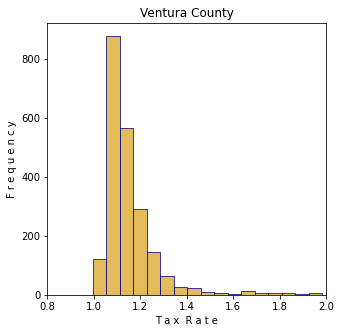

In [88]:
plt.figure(figsize=(5, 5))
plt.hist(Ventura.tax_rate, color = 'goldenrod', edgecolor='darkblue', bins = 50, alpha = 0.75, rwidth=600)
plt.title("Ventura County")

plt.xlabel('T a x  R a t e')
plt.ylabel('F r e q u e n c y')
plt.xlim([0.8, 2])
plt.show()

### ```Takeaways for Los Angeles County: ```
- The mean tax rate of all 20,705 observations in Los Angeles County is 1.322%
- The median tax rate is 1.24%. (The 50th percentile)
- The minimum tax rate is 0.09% and the maximum is 18.26%
- Standard deviation is 0.297
- Heaviest concentration between ~ 1.2% and 1.55%.

In [89]:
LA.describe()

,fips,tax_value,taxes,tax_rate
count,20754.000,20754.000,20754.000,20754.000
mean,6037.000,443934.544,5622.924,1.321
std,0.000,318935.675,3824.833,0.297
min,6037.000,90035.000,150.060,0.090
25%,6037.000,225264.250,3068.412,1.210
50%,6037.000,356451.500,4599.130,1.240
75%,6037.000,550000.000,6859.320,1.340
max,6037.000,1936324.000,61992.630,18.260


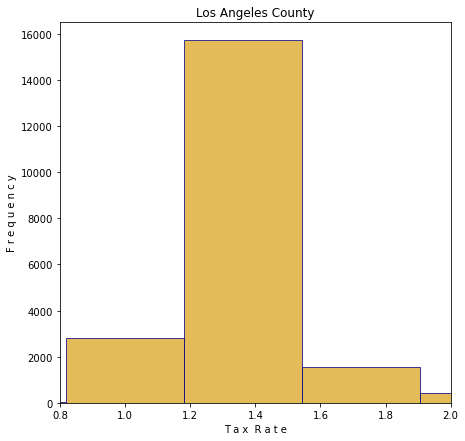

In [90]:
plt.figure(figsize=(7, 7))
plt.hist(LA.tax_rate, color = 'goldenrod', edgecolor='darkblue', bins = 50, alpha = 0.75, rwidth=600)
plt.title("Los Angeles County")

plt.xlabel('T a x  R a t e')
plt.ylabel('F r e q u e n c y')
plt.xlim([0.8, 2])
plt.show()

### ```Takeaways for Orange County: ```
- The mean tax rate of all 6,847 observations in Orange County is 1.176%
- The median tax rate is 1.150%. (The 50th percentile)
- The minimum tax rate is 0.12% and the maximum is 7.58%
- Standard deviation is 0.215
- Distribution is right skewed with the heaviest concentration between ~ 1.1% and 1.3%.

In [91]:
Orange.describe()

,fips,tax_value,taxes,tax_rate
count,6872.000,6872.000,6872.000,6872.000
mean,6059.000,573285.142,6610.482,1.176
std,0.000,350411.040,4075.035,0.215
min,6059.000,90056.000,343.520,0.120
25%,6059.000,326192.000,3750.110,1.050
50%,6059.000,500392.500,5721.400,1.150
75%,6059.000,737171.500,8315.215,1.230
max,6059.000,1931835.000,27447.100,7.580


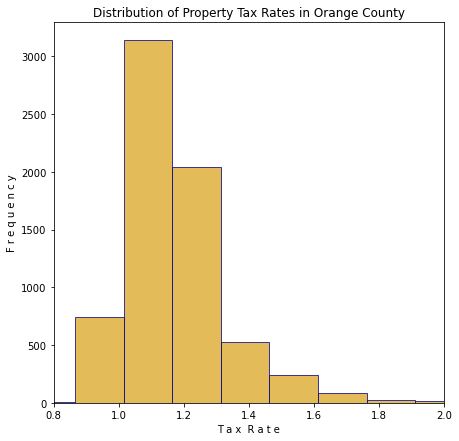

In [92]:
plt.figure(figsize=(7, 7))
plt.hist(Orange.tax_rate, color = 'goldenrod', edgecolor='darkblue', bins = 50, alpha = 0.75, rwidth=600)
plt.title("Distribution of Property Tax Rates in Orange County")

plt.xlabel('T a x  R a t e')
plt.ylabel('F r e q u e n c y')
plt.xlim([0.8, 2])
plt.show()

<a id='Recommends'></a>

### ```Final Recommendation and Takeaways:``` 

#### ```Takeaways from Evaluating Test Data on RMSE for Polynomial Model, degrees=2```

* **Recommend using the Polynomial Regression Model (degree of 2) to predict home values based on bathroom count, age of home, square footage and zip code.** 

* Note: Scatterplot visualization demonstrates that our model tends to under-value homes that exceed the median tax value of ~$408,000.

#### ```Given more Time and Resources, I would:```

- Fine tune feature engineering, perhaps combining some features, to increase accuracy.
- Since there was little difference in the RMSE for mean and median, I would re-run models using median as baseline, whereas median was $399,000 which may be more representativae
- Reconfigure many of my explorations and modeling code into as functions, to clean up notebook and increase reproducibility of results


